<a href="https://colab.research.google.com/github/jacr2006/android-tflitemodel-drowsiness-detection/blob/master/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset usado https://ibug.doc.ic.ac.uk/resources/300-W/

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pip install xmltodict

In [0]:
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

###**Datos**
Procesamiento de los datos: escalado y normalizacion

In [0]:
PATH_DRIVE = '/content/drive/My Drive/Proyectos Nuevos/ML/multiclass_landmark_keras_cnn/'
PATH_DATASET = 'ibug_300W_large_face_landmark_dataset/'
pathXml = PATH_DRIVE + PATH_DATASET + 'labels_ibug_300W.xml'# archivo con los datos de entrenamiento
with open(pathXml, 'r') as file:
  dict = xmltodict.parse(file.read())# lectura del archivo xml y conversion a diccionario

In [0]:
IMG_NUM=1263
pathImg = dict['dataset']['images']['image'][IMG_NUM]['@file']# ruta de la imagen

x=[]
y=[]
#for i in range(68):# marcas faciales de la imagen
for i in range(36,48):# marcas faciales de la imagen
  x.append( int(dict['dataset']['images']['image'][IMG_NUM]['box']['part'][i]['@x']) )
  y.append( int(dict['dataset']['images']['image'][IMG_NUM]['box']['part'][i]['@y']) )

left = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@left'] )# rectangulo sobre el rostro, asi que no es necesario usar ningun algoritmo de deteccion de rostros
top = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@top'] )
width = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@width'] )
height = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@height'] )

print(pathImg)
print(left)
print(top)
print(width)
print(height)


helen/trainset/212515669_1.jpg
232
108
373
373


Escalado de una imagen

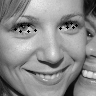

In [0]:
IMG_WIDTH = 96# tamaño de a imagen de entrada de la CNN
IMG_HEIGHT = 96
IMG_CHANNEL = 1# imagen en escala de grises

#N_LANDMARK = 68
N_LANDMARK = 12

img=cv2.imread( PATH_DRIVE + PATH_DATASET + pathImg )
cropImg = img[top:top+height, left:left+width]# recorte de la imagen al tamaño de la region de interes (ROI)

xcrop=[]
ycrop=[]
#for i in range(68):# escalado de las marcas faciales a la ROI
for i in range(12):# escalado de las marcas faciales a la ROI
  xcrop.append( x[i]-left )
  ycrop.append( y[i]-top )

mcrop=list(zip(xcrop,ycrop))

rezImg = cv2.resize( cropImg, ( IMG_WIDTH, IMG_HEIGHT ) )# escalado de la imagen usando opencv
grayImg = cv2.cvtColor(rezImg, cv2.COLOR_BGR2GRAY)# conversion de RGB a escala de grises con opencv.

xrez=[]
yrez=[]
#for i in range(68):# escalado de las marcas faciales en la misma proporcion de la imagen
for i in range(12):# escalado de las marcas faciales en la misma proporcion de la imagen
  xrez.append( int(xcrop[i]*IMG_WIDTH/cropImg.shape[0]) )
  yrez.append( int(ycrop[i]*IMG_HEIGHT/cropImg.shape[1]) )
  #print(str(xrez[i])+'-'+str(yrez[i]) )

marks=zip(xrez,yrez)

for (i, j) in marks:
  cv2.circle(grayImg, (i,j), 1, (0, 255, 0), -1)

cv2_imshow(grayImg)# despliegue de la imagen escalada y en escala de grises
#print(grayImg.shape)



Espejo de una imagen, con el proposito de hacer aumento de datos ("Data augmentation")

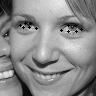

In [0]:
img=cv2.imread( PATH_DRIVE + PATH_DATASET + pathImg )
cropImg = img[top:top+height, left:left+width]# recorte de la imagen al tamaño de la region de interes (ROI)

xcrop=[]
ycrop=[]
#for i in range(68):# escalado de las marcas faciales a la ROI
for i in range(12):# escalado de las marcas faciales a la ROI
  xcrop.append( x[i]-left )
  ycrop.append( y[i]-top )

mcrop=list(zip(xcrop,ycrop))

rezImg = cv2.resize( cropImg, ( IMG_WIDTH, IMG_HEIGHT ) )# escalado de la imagen usando opencv
grayImg = cv2.cvtColor(rezImg, cv2.COLOR_BGR2GRAY)# conversion de RGB a escala de grises con opencv.
flipImg = cv2.flip(grayImg,1 )# espejo de la imagen

xrez=[]
yrez=[]
#for i in range(68):# escalado de las marcas faciales en la misma proporcion de la imagen
for i in range(12):# escalado de las marcas faciales en la misma proporcion de la imagen
  xrez.append( IMG_WIDTH-int(xcrop[i]*IMG_WIDTH/cropImg.shape[0]) )#espejo de las marcas faciales
  yrez.append( int(ycrop[i]*IMG_HEIGHT/cropImg.shape[1]) )
  #print(str(xrez[i])+'-'+str(yrez[i]) )

marks=zip(xrez,yrez)

for (i, j) in marks:
  cv2.circle(flipImg, (i,j), 1, (0, 255, 0), -1)

cv2_imshow(flipImg)# despliegue de la imagen escalada y en escala de grises



In [0]:
LEN=0
for i in dict['dataset']['images']['image']:
  LEN=LEN+1

print(LEN)

7674


Escalado y aumento de datos: espejado

In [0]:
dataset_array = np.zeros(shape=(LEN*2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
pts_array = np.zeros(shape=(LEN*2, N_LANDMARK, 2))
idx = 0
  
for i in dict['dataset']['images']['image']:# procesamiento de todo el dataset
  print(idx)
  pathImg = i['@file']# ruta de la imagen

  left = int(i['box']['@left'])# coordenadas del ROI
  top = int(i['box']['@top'])
  width = int(i['box']['@width'])
  height = int(i['box']['@height'])
  if ( width==0 or height==0 ) :
    continue

  xcrop=[]
  ycrop=[]
  for k in i['box']['part']:# lectura de las marcas faciales
    xcrop.append( int(k['@x'])-left )
    ycrop.append( int(k['@y'])-top )
  
  img=cv2.imread( PATH_DRIVE + PATH_DATASET + pathImg )# lectura de la imagen en tamaño real
  if ( img.shape[0]==0 or img.shape[1]==0 ) :
    continue
  cropImg = img[top:top+height, left:left+width]# recorte de la imagen al tamaño de la ROI
  print( cropImg.shape)
  if ( cropImg.shape[0]==0 or cropImg.shape[1]==0 ) :
    continue
  rezImg = cv2.resize( cropImg, ( IMG_WIDTH, IMG_HEIGHT ) )# escalado de la imagen
  grayImg = cv2.cvtColor(rezImg, cv2.COLOR_BGR2GRAY)# conversion de RGB a escala de grises
  rshImg = grayImg.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)  

  dataset_array[idx, :, :, :] = rshImg

  xrez=[]
  yrez=[]
  #for i in range(68):# escalado de las marcas faciales en la misma proporcion de la imagen
  for i in range(36,48):# escalado de las marcas faciales en la misma proporcion de la imagen
    xrez.append( int(xcrop[i]*IMG_WIDTH/cropImg.shape[0]) )
    yrez.append( int(ycrop[i]*IMG_HEIGHT/cropImg.shape[1]) )
  points=zip(xrez,yrez)  

  pts_array[idx, :, :] = list(points)

  #if ( min(xrez)<-24 or max(xrez)>120 or min(yrez)<-24 or max(yrez)>120):# se suprimen las imagenes con marcas fuera de rectangulo mas alla del 25%
  if ( min(xrez)<0 or max(xrez)>96 or min(yrez)<0 or max(yrez)>96):# se suprimen las imagenes con marcas fuera de rectangulo mas alla del 25%
    print("out of scale")
  else :
    idx=idx+1

for i in dict['dataset']['images']['image']:# procesamiento de todo el dataset
  print(idx)
  pathImg = i['@file']# ruta de la imagen

  left = int(i['box']['@left'])# coordenadas del ROI
  top = int(i['box']['@top'])
  width = int(i['box']['@width'])
  height = int(i['box']['@height'])
  if ( width==0 or height==0 ) :
    continue

  xcrop=[]
  ycrop=[]
  for k in i['box']['part']:# lectura de las marcas faciales
    xcrop.append( int(k['@x'])-left )
    ycrop.append( int(k['@y'])-top )
  
  img=cv2.imread( PATH_DRIVE + PATH_DATASET + pathImg )# lectura de la imagen en tamaño real
  if ( img.shape[0]==0 or img.shape[1]==0 ) :
    continue
  cropImg = img[top:top+height, left:left+width]# recorte de la imagen al tamaño de la ROI
  print( cropImg.shape)
  if ( cropImg.shape[0]==0 or cropImg.shape[1]==0 ) :
    continue
  rezImg = cv2.resize( cropImg, ( IMG_WIDTH, IMG_HEIGHT ) )# escalado de la imagen
  grayImg = cv2.cvtColor(rezImg, cv2.COLOR_BGR2GRAY)# conversion de RGB a escala de grises
  rshImg = grayImg.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)  

  flipImg = cv2.flip(rshImg, 1)    
  flipImg = flipImg.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)#espejado
  
  dataset_array[idx, :, :, :] = flipImg#data aumentada  

  xflip=[]
  yflip=[]
  #for i in range(68):# escalado de las marcas faciales en la misma proporcion de la imagen
  for i in range(36,48):# escalado de las marcas faciales en la misma proporcion de la imagen
    xflip.append( IMG_WIDTH-int(xcrop[i]*IMG_WIDTH/cropImg.shape[0]) )
    yflip.append( int(ycrop[i]*IMG_HEIGHT/cropImg.shape[1]) )
  pointsFlip=zip(xflip,yflip)

  pts_array[idx, :, :] = list(pointsFlip)#data aumentada  

  #if ( min(xrez)<-24 or max(xrez)>120 or min(yrez)<-24 or max(yrez)>120):# se suprimen las imagenes con marcas fuera de rectangulo mas alla del 25%
  if ( min(xflip)<0 or max(xflip)>96 or min(yflip)<0 or max(yflip)>96):# se suprimen las imagenes con marcas fuera de rectangulo mas alla del 25%
    print("out of scale")
  else :
    idx=idx+1


0
(216, 216, 3)
1
(150, 150, 3)
2
(180, 180, 3)
3
(259, 259, 3)
4
(259, 259, 3)
5
(180, 180, 3)
6
(216, 216, 3)
7
(216, 216, 3)
8
(216, 216, 3)
9
(216, 216, 3)
10
(180, 180, 3)
11
(195, 193, 3)
12
(259, 259, 3)
13
(229, 211, 3)
14
(216, 216, 3)
15
(231, 227, 3)
16
(216, 216, 3)
17
(216, 216, 3)
18
(259, 259, 3)
19
(180, 181, 3)
20
(259, 259, 3)
21
(259, 259, 3)
22
(105, 98, 3)
23
(262, 261, 3)
24
(259, 259, 3)
25
(331, 337, 3)
26
(151, 151, 3)
27
(126, 125, 3)
28
(105, 105, 3)
29
(121, 122, 3)
30
(87, 88, 3)
31
(105, 105, 3)
32
(125, 129, 3)
33
(134, 131, 3)
34
(105, 104, 3)
35
(182, 181, 3)
36
(180, 180, 3)
37
(180, 181, 3)
38
(180, 181, 3)
39
(231, 245, 3)
40
(150, 150, 3)
41
(126, 125, 3)
42
(150, 151, 3)
43
(125, 126, 3)
44
(150, 150, 3)
45
(150, 151, 3)
46
(216, 216, 3)
47
(210, 217, 3)
48
(208, 214, 3)
49
(259, 259, 3)
50
(217, 217, 3)
51
(180, 180, 3)
52
(151, 151, 3)
53
(373, 373, 3)
54
(104, 105, 3)
55
(210, 213, 3)
56
(216, 216, 3)
57
(216, 216, 3)
58
(372, 373, 3)
59
(372, 3

##Limpieza del dataset
Se filtran imagenes con marcas fuera de rango del dataset.

In [0]:
print(dataset_array.shape)
data = dataset_array[0:7509,:,:,:]
data_aument = dataset_array[0:15019,:,:,:]
print(data.shape)
print(data_aument.shape)

print(pts_array.shape)
pts = pts_array[0:7509,:,:]
pts_aument = pts_array[0:15019,:,:]
print(pts.shape)
print(pts_aument.shape)


(15348, 96, 96, 1)
(7509, 96, 96, 1)
(15019, 96, 96, 1)
(15348, 12, 2)
(7509, 12, 2)
(15019, 12, 2)


Visualizacion de la data, para chequeo del aumento de datos

(7509, 96, 96, 1)
(7509, 12, 2)
(96, 96)
(12, 2)


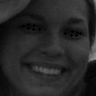

In [0]:
SAMPLE=1
print(data.shape)
print(pts.shape)
img_sample=data[SAMPLE,:,:,0]
print(img_sample.shape)
mark_samples=pts[SAMPLE,:,:]
print(mark_samples.shape)

for i in range(12):
  cv2.circle(img_sample, ( int(mark_samples[i,0]),int(mark_samples[i,1]) ), 1, (0, 255, 0), -1)

cv2_imshow(img_sample)# despliegue de la imagen escalada y en escala de grises

Se guarda la data para el entrenamiento posterior

In [0]:
np.save(PATH_DRIVE + "img.npy", data)#dataset original
np.save(PATH_DRIVE + "pts.npy", pts)

np.save(PATH_DRIVE + "img_aument.npy", data_aument)#dataset original + aumentado
np.save(PATH_DRIVE + "pts_aument.npy", pts_aument)